### Задание.

Примените технологию residual connection для нейросети из лаборатороной работы № 1. Сделайте отображение величины ошибки для тренировочной и валидационной выборки нак графике в процесе вычислений (аналогично примеру выше). Отобразите результат классификации с указанием класса-результата и верного ответа для 10 случайныз картинок тестовой выборки (аналогично примеру выше).

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import Imagenette
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загружаем набор данных
train = Imagenette(root='./data/train', split='train', size="160px", transform=transform, download=True)
test = Imagenette(root='./data/val', split='val', size="160px", transform=transform, download=True)

# Создаем загрузчики данных
train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

# Пример итерации по данным
for images, labels in train_loader:
    print(f'Batch size: {images.shape}')  # Выводит размер батча изображений
    print(f'Labels: {labels.shape}')      # Выводит размер батча меток
    break                                 # Выход после первого батча


100%|██████████| 99.0M/99.0M [00:40<00:00, 2.46MB/s]


Extracting ./data/train\imagenette2-160.tgz to ./data/train


100%|██████████| 99.0M/99.0M [00:18<00:00, 5.50MB/s]


Extracting ./data/val\imagenette2-160.tgz to ./data/val
Batch size: torch.Size([32, 3, 96, 96])
Labels: torch.Size([32])


In [4]:
# Формируем x_train и y_train
x_train = []
y_train = []

for images, labels in train_loader:
    x_train.append(images)
    y_train.append(labels)

# Конвертируем в тензоры
x_train = torch.cat(x_train)  # Объединяем все изображения в один тензор
y_train = torch.cat(y_train)  # Объединяем все метки в один тензор

# Формируем x_test и y_test
x_test = []
y_test = []

for images, labels in test_loader:
    x_test.append(images)
    y_test.append(labels)

# Конвертируем в тензоры
x_test = torch.cat(x_test)  # Объединяем все тестовые изображения в один тензор
y_test = torch.cat(y_test)  # Объединяем все тестовые метки в один тензор

In [5]:
y_train

tensor([2, 5, 6,  ..., 9, 6, 0])

In [6]:
# Печатаем размеры полученных данных
print(f'x_train shape: {x_train.shape}')  # Размеры обучающих изображений
print(f'y_train shape: {y_train.shape}')  # Размеры обучающих меток
print(f'x_test shape: {x_test.shape}')    # Размеры тестовых изображений
print(f'y_test shape: {y_test.shape}')    # Размеры тестовых меток

x_train shape: torch.Size([9469, 3, 96, 96])
y_train shape: torch.Size([9469])
x_test shape: torch.Size([3925, 3, 96, 96])
y_test shape: torch.Size([3925])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

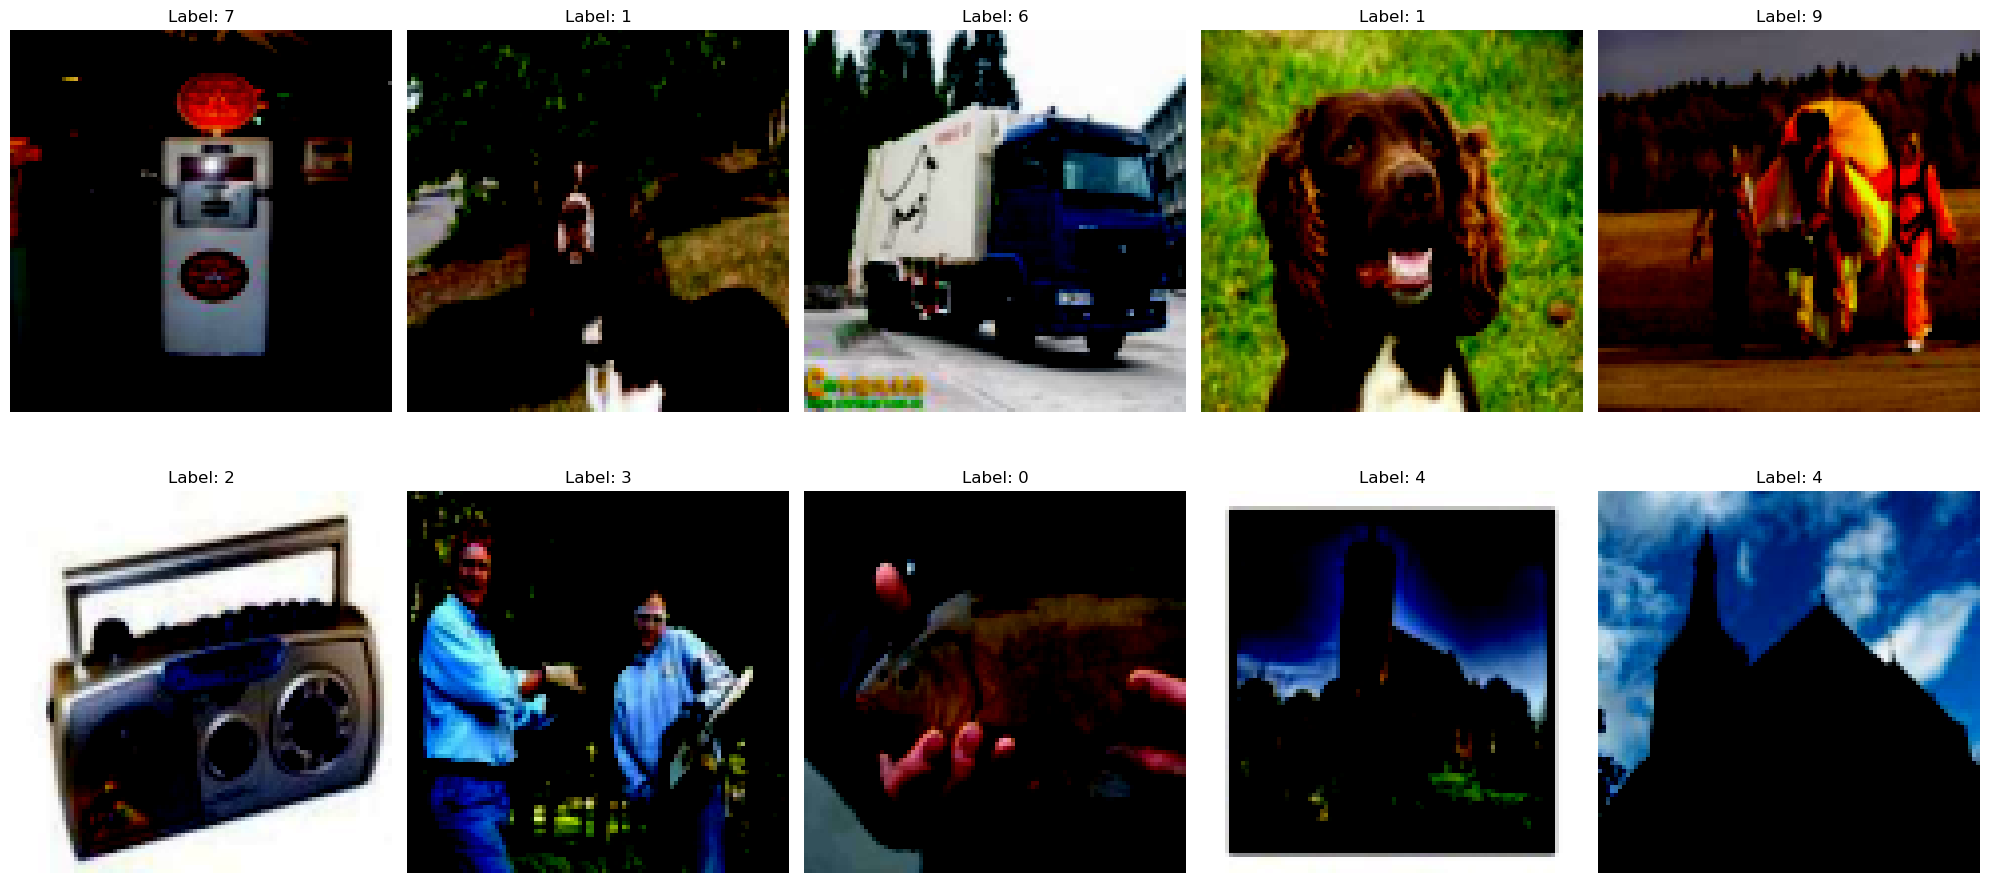

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры для выборки и визуализации
sample_size = 10  # количество изображений для визуализации

# Инициализация графика
plt.figure(figsize=(20, 10))

# Случайная выборка индексов изображений
indices = np.random.permutation(x_train.shape[0])[:sample_size]

for count, i in enumerate(indices):
    plt.subplot(2, 5, count + 1)  # Разделение на 2 строки и 5 колонок
    plt.imshow(x_train[i].permute(1, 2, 0).numpy(), cmap='viridis')  # Преобразуем (C, H, W) в (H, W, C) для отображения
    plt.title(f'Label: {y_train[i].item()}')  # Отображаем метку
    plt.axis('off')                           # Убираем оси

plt.tight_layout()
plt.show()


In [ ]:
# сколько изображений в трейне и тесте
len(y_train), len(y_test)

In [8]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        
        # Первый сверточный слой с фильтрами 3x3
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()  # Активация ReLU после первого сверточного слоя
        
        # Второй сверточный слой с фильтрами 3x3
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()  # Активация ReLU после второго сверточного слоя

        # Соединение со шорткатом: сверточный слой 1x1, если размеры каналов различаются
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        else:
            self.shortcut = None  # Преобразование не требуется, если размеры совпадают

    def forward(self, x):
        # Применяем соединение со шорткатом
        residual = x if self.shortcut is None else self.shortcut(x)
        
        # Пропускаем вход через первый сверточный слой
        out = self.conv1(x)
        out = self.act1(out)  # Применяем активацию
        # Пропускаем через второй сверточный слой
        out = self.conv2(out)
        
        # Добавляем остаточный (шорткат)
        out += residual
        out = self.act2(out)  # Применяем активацию после сложения

        return out

In [9]:
class ResidualModel(nn.Module):
    def __init__(self):
        super(ResidualModel, self).__init__()
        
        # Определяем остаточные блоки с соответствующими входными и выходными каналами
        self.layer1 = ResidualBlock(3, 16)  # Вход: 3 канала (RGB), Выход: 16 каналов
        self.layer2 = ResidualBlock(16, 32)  # Вход: 16 каналов, Выход: 32 канала
        
        # Слой среднего пулинга для уменьшения пространственных размеров
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(32 * 24 * 24, 120)  # Корректируем размер входа на основе пулинга
        self.fc2 = nn.Linear(120, 10)  # Выход: 10 классов

    def forward(self, x):
        x = self.layer1(x)  # Прямое прохождение через первый остаточный блок
        x = self.pool(x)    # Средний пулинг

        x = self.layer2(x)  # Прямое прохождение через второй остаточный блок
        x = self.pool(x)    # Средний пулинг

        x = x.view(x.size(0), -1)  # Преобразуем выход в плоский (flatten) для полносвязных слоев

        x = self.fc1(x)     # Прямое прохождение через первый полносвязный слой
        x = self.fc2(x)     # Прямое прохождение через второй полносвязный слой

        return x            # Возвращаем выходной тензор

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = ResidualModel().to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Обучение с отображением величины ошибки
num_epochs = 50
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()  # Устанавливаем модель в режим обучения

    # Обучающая выборка
    for images, labels in train_loader:  # Используем DataLoader для загрузки по батчам
        images, labels = images.to(device), labels.to(device)  # Переносим на устройство
        optimizer.zero_grad()  # Обнуляем градиенты
        preds = model(images)  # Прогнозируем
        loss = loss_fn(preds, labels)  # Вычисляем потерю
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Шаг оптимизации
        train_loss_history.append(loss.item())

    # Валидационная выборка
    model.eval()  # Устанавливаем модель в режим валидации
    with torch.no_grad():  # Отключаем градиенты
        for images, labels in test_loader:  # Используем DataLoader для валидации
            images, labels = images.to(device), labels.to(device)  # Переносим на устройство
            val_preds = model(images)  # Прогнозируем
            val_loss = loss_fn(val_preds, labels)  # Вычисляем потерю
            val_loss_history.append(val_loss.item())

    # Вывод информации
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch [1/50], Train Loss: 0.9381, Val Loss: 1.6797
Epoch [2/50], Train Loss: 0.9908, Val Loss: 1.2164
Epoch [3/50], Train Loss: 0.6668, Val Loss: 1.4995
Epoch [4/50], Train Loss: 0.6522, Val Loss: 1.8273
Epoch [5/50], Train Loss: 0.4448, Val Loss: 1.9365
Epoch [6/50], Train Loss: 0.1528, Val Loss: 2.7365
Epoch [7/50], Train Loss: 0.0608, Val Loss: 2.3505
Epoch [8/50], Train Loss: 0.0990, Val Loss: 2.9007
Epoch [9/50], Train Loss: 0.0252, Val Loss: 3.4660
Epoch [10/50], Train Loss: 0.0638, Val Loss: 3.1004
Epoch [11/50], Train Loss: 0.0643, Val Loss: 3.2685
Epoch [12/50], Train Loss: 0.0548, Val Loss: 4.0054
Epoch [13/50], Train Loss: 0.0528, Val Loss: 4.2754
Epoch [14/50], Train Loss: 0.0632, Val Loss: 4.4098
Epoch [15/50], Train Loss: 0.0185, Val Loss: 4.1493
Epoch [16/50], Train Loss: 0.0055, Val Loss: 5.6488
Epoch [17/50], Train Loss: 0.1383, Val Loss: 4.2303
Epoch [18/50], Train Loss: 0.0194, Val Loss: 3.8779
Epoch [19/50], Train Loss: 0.0103, Val Loss: 2.7138
Epoch [20/50], Train 

In [47]:
import matplotlib.pyplot as plt
import torch

def show_results(model, x_test, y_test, h=5, w=4):
    with torch.no_grad():
        # Генерируем случайные индексы для тестового набора
        batch_indices = torch.randint(0, x_test.shape[0], (h * w,))
        # Получаем вероятности предсказаний от модели
        batch_probs = model(x_test[batch_indices].to(device)).exp()

        # Создаем фигуру для отображения результатов
        fig, ax = plt.subplots(h, w, figsize=(30, 12 * h))
        for i in range(h * w):
            plt.subplot(h, w, i + 1)
            # Отображаем изображение в RGB
            img = x_test[batch_indices[i]].cpu().permute(1, 2, 0).numpy()  # Изменяем порядок осей с (C, H, W) на (H, W, C)
            plt.imshow(img)
            
            # Подготовка заголовка
            title = f'Реальный класс: {y_test[batch_indices[i]].item()}\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])
            for j, prob in enumerate(batch_probs[i]):
                title += '\n{}{}{: <10} : {:.4f}'.format(
                    "" if j != y_pred else "> ",
                    "" if j != y_test[batch_indices[i]].item() else "+ ",
                    j,
                    prob.item(),
                )

            plt.title(title, fontsize='20', loc='left')
            plt.xticks([])  # Убираем метки по оси x
            plt.yticks([])  # Убираем метки по оси y
        plt.tight_layout()  # Чтобы избежать наложения заголовков
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

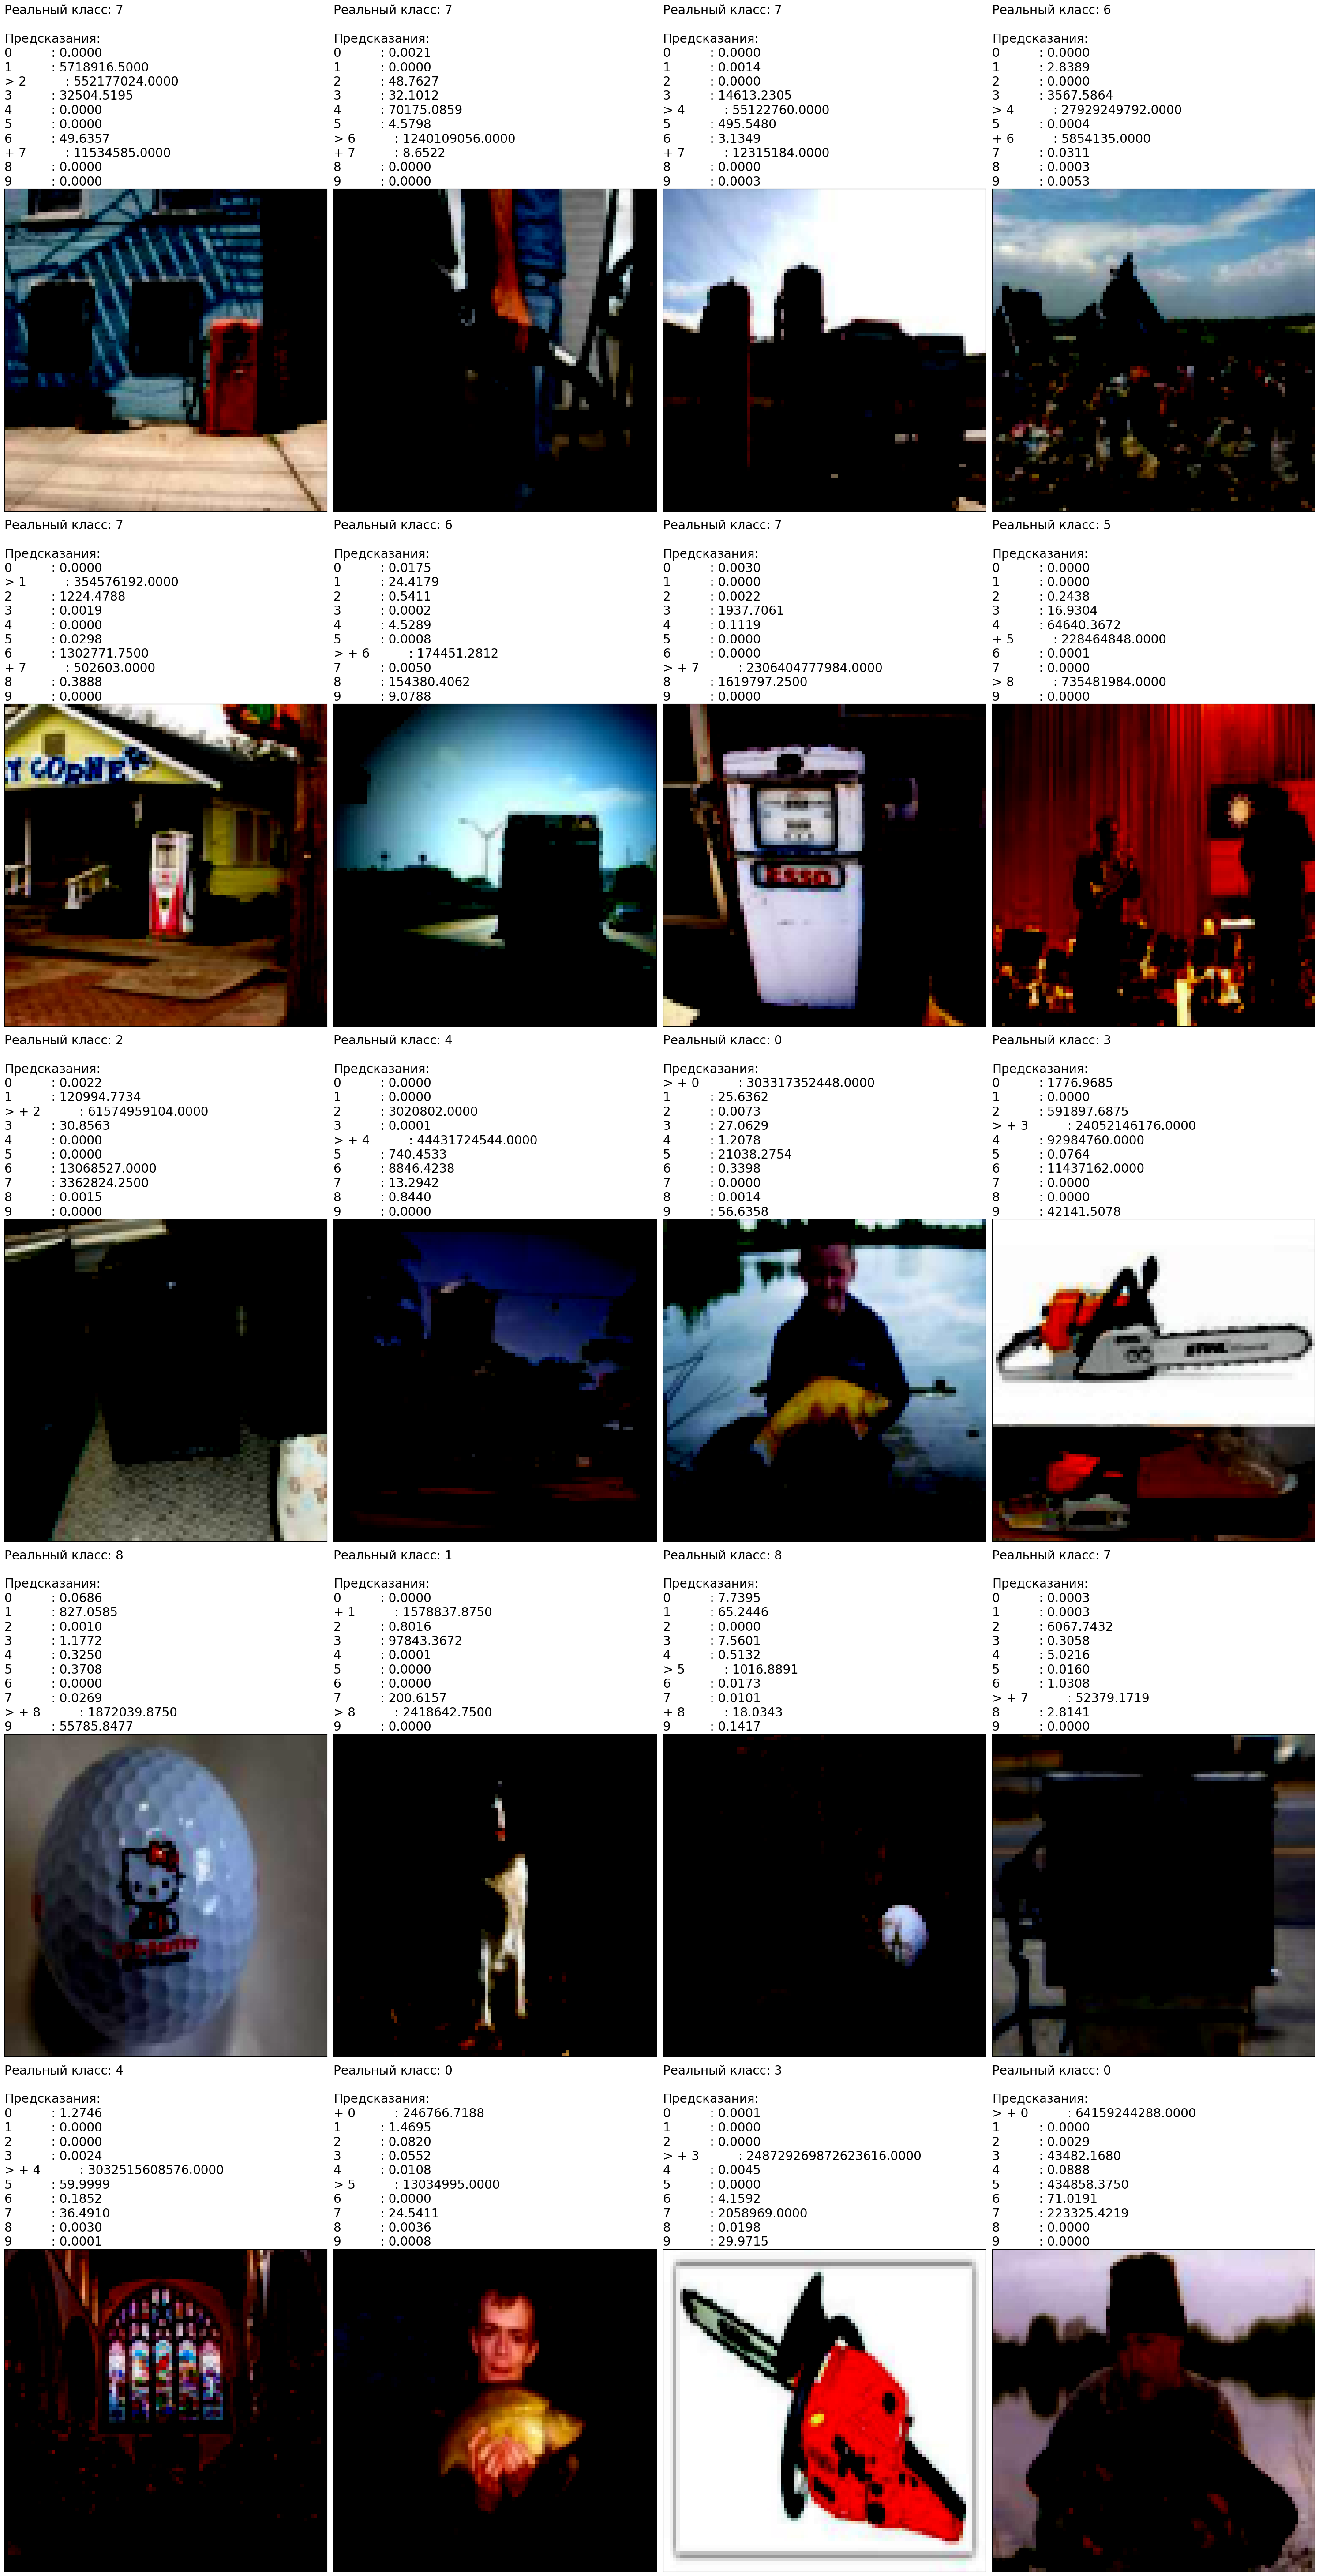

In [48]:
show_results(model, x_test, y_test)